##Importando Bibliotecas

In [1]:
import pandas as pd
import numpy             as np
import matplotlib.pyplot as plt
import matplotlib.dates  as mdates
import seaborn           as sbn
import statsmodels.api   as sm


from google.colab import auth
from google.colab import files
from google.oauth2 import service_account
from matplotlib.ticker         import FuncFormatter
from statsmodels.tsa.stattools import acf, pacf
from statsmodels.tsa.stattools import adfuller as adf
from sklearn.model_selection   import train_test_split
from statsmodels.tsa.seasonal  import seasonal_decompose
from statsmodels.tsa.arima.model import ARIMA
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error

##Extraindo dados

In [ ]:
url = "http://www.ipeadata.gov.br/ExibeSerie.aspx?module=m&serid=1650971490&oper=view"
tables = pd.read_html(url, encoding='utf-8')

df = tables[2]

In [ ]:
df.columns = df.iloc[0]
df = df.iloc[1:]

In [ ]:
df.columns = ['Data', 'Preco_petroleo']

In [ ]:
df.to_csv('ipea_df.csv',index=False)

##Fazendo upload do arquivo no bucket

In [ ]:
#CODIGO PARA FAZER UPLOAD DO ARQUIVO .CSV AO BUCKET
!gcloud auth activate-service-account --key-file={'/content/gcp-tech-challenge-d6e951545c21.json'}
!gsutil cp ipea_df.csv gs://{'raw_data_ipea'}/ipea_df.csv

Activated service account credentials for: [gcp-tech-challenge@gcp-tech-challenge.iam.gserviceaccount.com]
Copying file://ipea_df.csv [Content-Type=text/csv]...
-
Operation completed over 1 objects/176.4 KiB.                                    


##Lendo arquivos direto do bucket

In [ ]:
# prompt: a code to read or donwload .csv files from google storage

!gcloud auth activate-service-account --key-file={'/content/gcp-tech-challenge-d6e951545c21.json'}
!gsutil cp gs://{'raw_data_ipea'}/ipea_df.csv ipea_df.csv


Activated service account credentials for: [gcp-tech-challenge@gcp-tech-challenge.iam.gserviceaccount.com]
Copying gs://raw_data_ipea/ipea_df.csv...
/ [1 files][176.4 KiB/176.4 KiB]                                                
Operation completed over 1 objects/176.4 KiB.                                    


In [ ]:
df_ipea = pd.read_csv('ipea_df.csv',sep=',')
df_ipea.head()

,Data,Preco_petroleo
0,18/06/2024,8479
1,17/06/2024,8245
2,14/06/2024,8149
3,13/06/2024,8144
4,12/06/2024,8052


In [ ]:
df_ipea.duplicated().sum()

0

In [ ]:
df_ipea.isnull().sum()

Data              0
Preco_petroleo    0
dtype: int64

In [ ]:
df_ipea.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 11194 entries, 0 to 11193
Data columns (total 2 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   Data            11194 non-null  object
 1   Preco_petroleo  11194 non-null  int64 
dtypes: int64(1), object(1)
memory usage: 175.0+ KB


In [ ]:
df_ipea['Preco_petroleo'] = df_ipea['Preco_petroleo'].astype(int)
df_ipea['Preco_petroleo'] = df_ipea['Preco_petroleo'].apply(lambda x: float(f"{x // 100}.{x % 100:02}"))

In [ ]:
df_ipea['Data'] = pd.to_datetime(df_ipea['Data'], format='%d/%m/%Y', errors='coerce')

In [ ]:
df_ipea.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 11194 entries, 0 to 11193
Data columns (total 2 columns):
 #   Column          Non-Null Count  Dtype         
---  ------          --------------  -----         
 0   Data            11194 non-null  datetime64[ns]
 1   Preco_petroleo  11194 non-null  float64       
dtypes: datetime64[ns](1), float64(1)
memory usage: 175.0 KB


In [ ]:
df_ipea.head()

,Data,Preco_petroleo
0,2024-06-18,84.79
1,2024-06-17,82.45
2,2024-06-14,81.49
3,2024-06-13,81.44
4,2024-06-12,80.52


In [ ]:
df_ipea.describe().round(2)

,Data,Preco_petroleo
count,11194,11194.00
mean,2006-08-21 17:32:32.117205504,53.08
min,1987-05-20 00:00:00,9.10
25%,1998-05-28 06:00:00,20.51
50%,2007-04-08 12:00:00,48.34
75%,2015-01-08 18:00:00,76.57
max,2024-06-18 00:00:00,143.95
std,NaN,33.22


In [ ]:
df_ipea.to_csv('df_ipea.csv',sep=',',index=False,float_format='%.2f')

In [ ]:
# Definir as datas de início e fim para o filtro
start_date = '2014-06-01'
end_date = '2024-06-01'
# Filtrar o DataFrame usando o método loc
df_ipea10y = df_ipea.loc[(df_ipea['Data'] >= start_date) & (df_ipea['Data'] <= end_date)]
df_ipea10y.shape

(3007, 2)

In [ ]:
df_ipea10y.head()

,Data,Preco_petroleo
12,2024-05-31,79.41
13,2024-05-30,81.42
14,2024-05-29,81.50
15,2024-05-28,81.34
16,2024-05-24,78.92


<class 'pandas.core.frame.DataFrame'>
Index: 3007 entries, 12 to 3018
Data columns (total 2 columns):
 #   Column          Non-Null Count  Dtype         
---  ------          --------------  -----         
 0   Data            3007 non-null   datetime64[ns]
 1   Preco_petroleo  3007 non-null   float64       
dtypes: datetime64[ns](1), float64(1)
memory usage: 70.5 KB


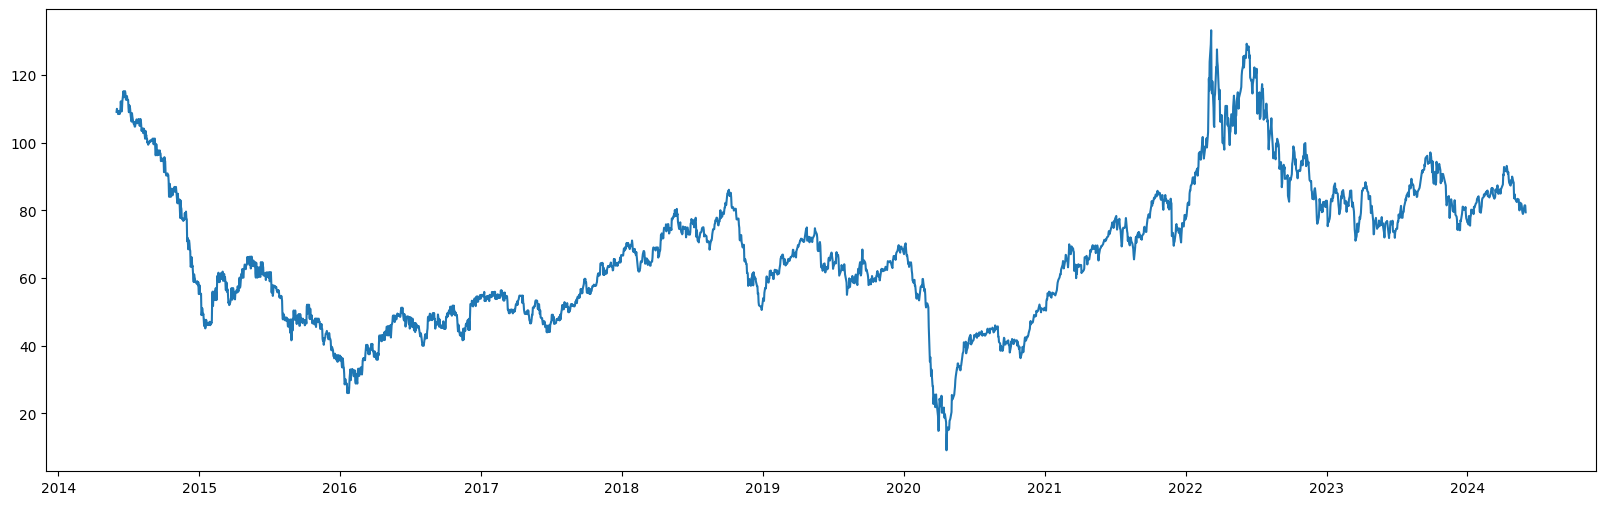

In [ ]:
plt.figure(figsize=(20, 6))
plt.plot(df_ipea10y.Data, df_ipea10y.Preco_petroleo)
df_ipea10y.info()

##Modelo Arima

In [ ]:
df_ipea10y.info()

<class 'pandas.core.frame.DataFrame'>
Index: 3007 entries, 6 to 3012
Data columns (total 2 columns):
 #   Column          Non-Null Count  Dtype         
---  ------          --------------  -----         
 0   Data            3007 non-null   datetime64[ns]
 1   Preco_petroleo  3007 non-null   float64       
dtypes: datetime64[ns](1), float64(1)
memory usage: 70.5 KB


In [ ]:
df_ipea10y.set_index('Data', inplace = True)
df_resample = df_ipea10y.resample('M').mean()

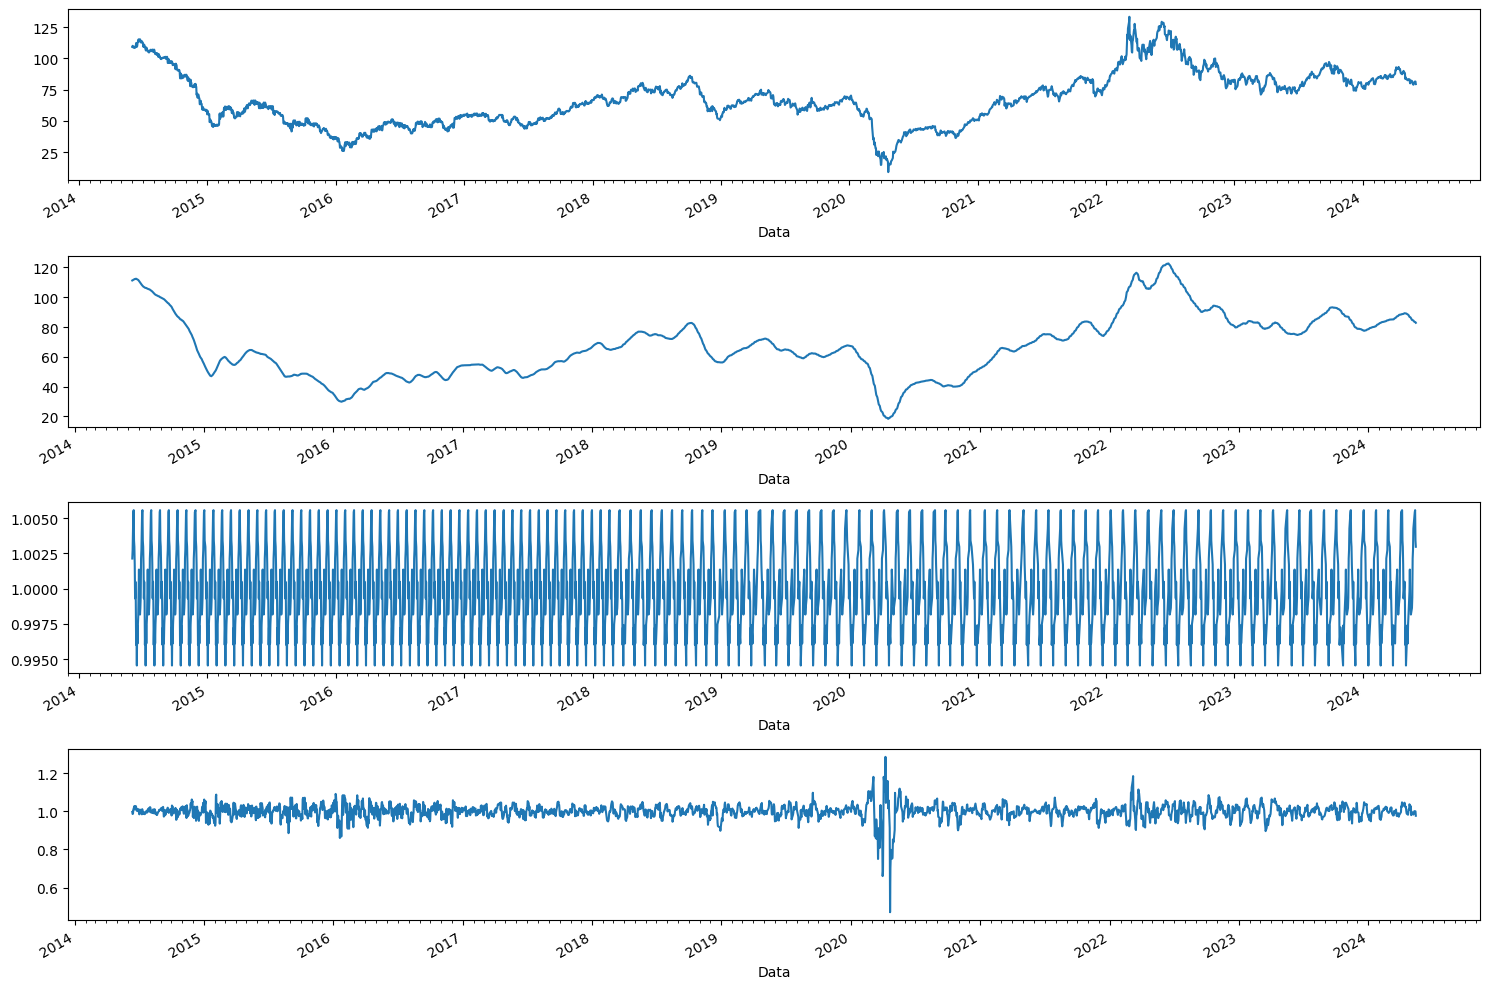

In [ ]:
#Analisando a tendencia, sazionalidade e residuos
seasonal_analysis = seasonal_decompose(df_ipea10y, model='multiplpicative', period=25)

fig, (ax1, ax2, ax3, ax4) = plt.subplots(4, 1, figsize=(15,10))
seasonal_analysis.observed.plot(ax=ax1)
seasonal_analysis.trend.plot(ax=ax2)
seasonal_analysis.seasonal.plot(ax=ax3)
seasonal_analysis.resid.plot(ax=ax4)

date_format = mdates.DateFormatter('%Y')
for ax in [ax1, ax2, ax3, ax4]:
    ax.xaxis.set_major_formatter(date_format)
    ax.xaxis.set_major_locator(mdates.YearLocator())
    ax.xaxis.set_minor_locator(mdates.MonthLocator())


plt.tight_layout()

plt.show()

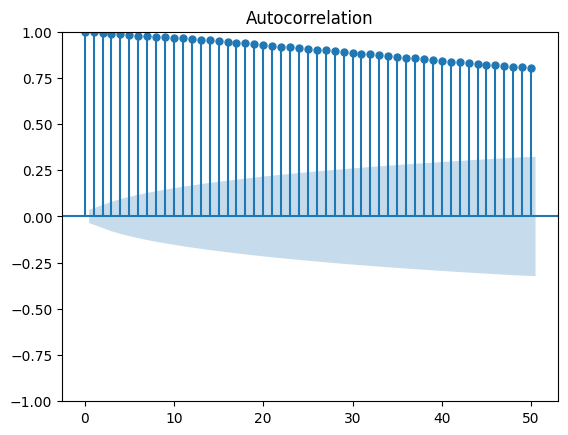

In [ ]:
sm.graphics.tsa.plot_acf(df_ipea10y, lags=50)

plt.show()

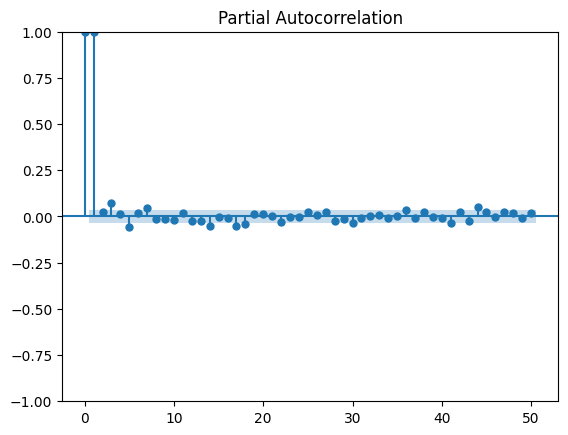

In [ ]:
sm.graphics.tsa.plot_pacf(df_ipea10y, lags=50)

plt.show()

In [ ]:
#ANALISANDO SERIE TEMPORAL
df_mean = df_ipea10y.rolling(window=12).mean()
df_std = df_ipea10y.rolling(window=12).std()


In [ ]:
df_ipea10y.describe()

,Preco_petroleo
count,3007.000000
mean,65.801689
std,20.558926
min,9.120000
25%,49.525000
50%,63.520000
75%,79.225000
max,133.180000


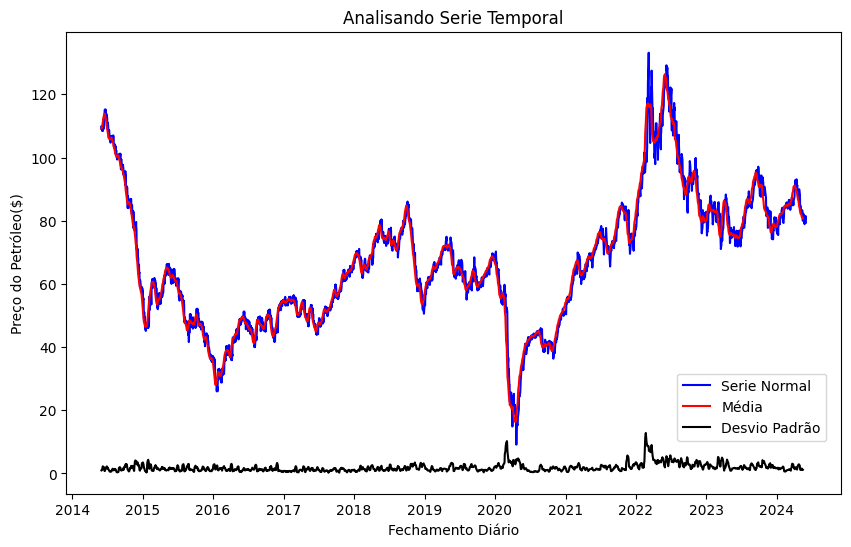

In [ ]:
plt.figure(figsize=(10,6))

plt.title('Analise Preço Petróleo')
plt.ylabel('Preço do Petróleo($)')
plt.xlabel('Fechamento Diário')

ax = plt.gca()
# def fomatar_eixo_y_milhar(x, pos):
#     return '{:.3f}'.format(x)
ax.xaxis.set_major_locator(mdates.YearLocator())
# ax.yaxis.set_major_formatter(FuncFormatter(fomatar_eixo_y_milhar))


invest = plt.plot(df_ipea10y, color='blue', label='Serie Normal')
invest_mean = plt.plot(df_mean, color='red', label='Média')
invest_std = plt.plot(df_std, color='black', label='Desvio Padrão')
plt.title('Analisando Serie Temporal')
plt.legend(loc='lower right')

plt.legend(loc='lower right', bbox_to_anchor=(0.99, 0.1))

plt.show(block=False)

In [ ]:
#Validando a estacionariedade da serie temporal através do teste de Dickey - Fuller


adf_result = adf(df_ipea10y['Preco_petroleo'])
print(f'ADF: {adf_result[0]}')
print(f'Valor p: {adf_result[1]}')
print('****VALORES CRITICOS****')
for key, value in adf_result[4].items():
    print(f'   {key}: {value}')
print('Série não é estacionaria: valor p > 0.05. Valores críticos abaixo do ADF ')

ADF: -1.9419906353917658
Valor p: 0.3125723818952188
****VALORES CRITICOS****
   1%: -3.4325396703967974
   5%: -2.862507454335551
   10%: -2.5672850015989264
Série não é estacionaria: valor p > 0.05. Valores críticos abaixo do ADF 


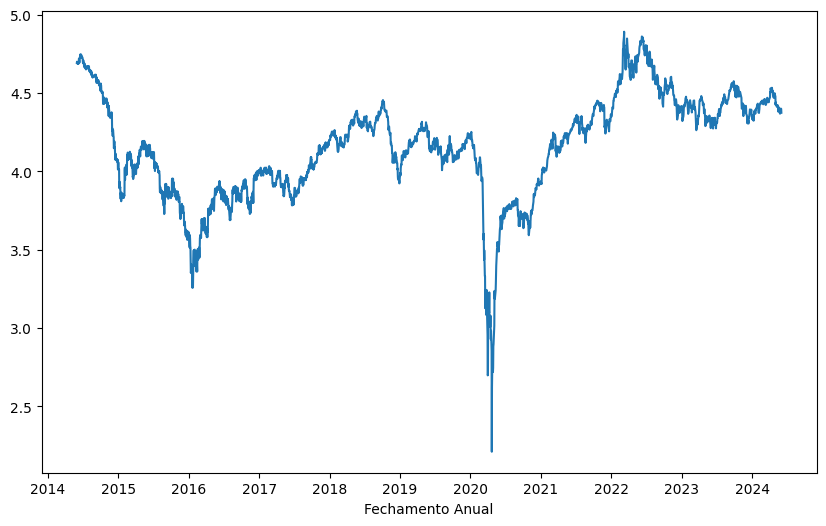

In [ ]:
#Fazendo a diferenciação através de logaritmos
indexedDataset_logScale = np.log(df_ipea10y)


plt.figure(figsize=(10,6))
plt.title('')
plt.ylabel('')
plt.xlabel('Fechamento Anual')

ax = plt.gca()
def fomatar_eixo_y_milhar(x, pos):
    return '{:.1f}'.format(x)
ax.xaxis.set_major_locator(mdates.YearLocator())
ax.yaxis.set_major_formatter(FuncFormatter(fomatar_eixo_y_milhar))


plt.plot(indexedDataset_logScale)

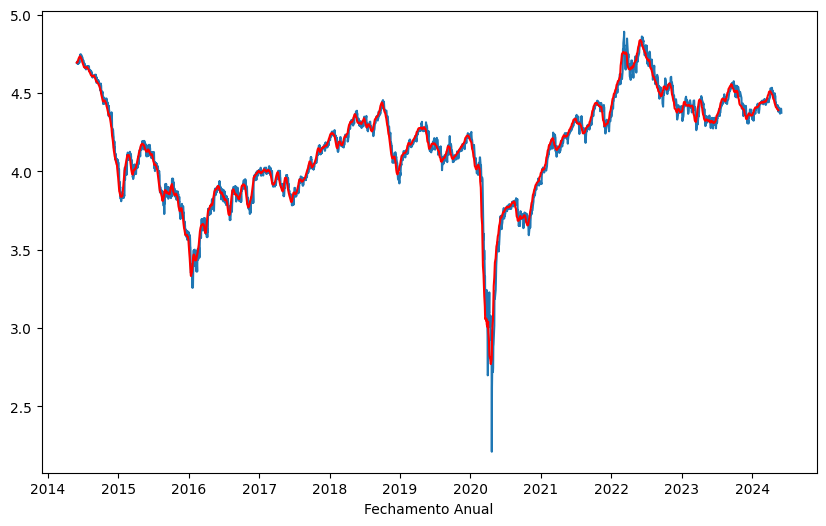

In [ ]:
movingAverage = indexedDataset_logScale.rolling(window=12).mean()
movingSTD = indexedDataset_logScale.rolling(window=12).std()



plt.figure(figsize=(10,6))
plt.title('')
plt.ylabel('')
plt.xlabel('Fechamento Anual')

ax = plt.gca()
def fomatar_eixo_y_milhar(x, pos):
    return '{:.1f}'.format(x)
ax.xaxis.set_major_locator(mdates.YearLocator())
ax.yaxis.set_major_formatter(FuncFormatter(fomatar_eixo_y_milhar))


plt.plot(indexedDataset_logScale)
plt.plot(movingAverage, color='red')

In [ ]:
datasetLogScaleMinusMovingAverage = indexedDataset_logScale - movingAverage
datasetLogScaleMinusMovingAverage.head(5)

datasetLogScaleMinusMovingAverage.dropna(inplace=True)
datasetLogScaleMinusMovingAverage.head(5)

,Preco_petroleo
Data,
2024-05-15,-0.009219
2024-05-14,0.001802
2024-05-13,0.026577
2024-05-10,0.027188
2024-05-09,0.023794


In [ ]:
def test_stationarity(timeseries):


    movingAverage = timeseries.rolling(window=12).mean()
    movingSTD = timeseries.rolling(window=12).std()


    plt.figure(figsize=(10,6))
    invest = plt.plot(timeseries, color='blue', label='Serie Normal')
    invest_mean = plt.plot(movingAverage, color='red', label='Média')
    invest_std = plt.plot(movingSTD, color='black', label='Desvio Padrão')




    ax = plt.gca()
    ax.xaxis.set_major_locator(mdates.YearLocator())


    plt.title('Analisando Serie Temporal Estacionaria')
    plt.ylabel('')
    plt.xlabel('')
    plt.legend(loc='upper right')




    print('Results of Dickey Fuller Test:')
    dftest = adf(timeseries['Preco_petroleo'], autolag='AIC')
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
    for key,value in dftest[4].items():
        dfoutput['Critical Value (%s)'%key] = value
    print(dfoutput)
    print('Série estacionária, pois o p value < 0.05')
    plt.show(block=False)

Results of Dickey Fuller Test:
Test Statistic                -8.912845e+00
p-value                        1.092464e-14
#Lags Used                     2.700000e+01
Number of Observations Used    2.968000e+03
Critical Value (1%)           -3.432555e+00
Critical Value (5%)           -2.862514e+00
Critical Value (10%)          -2.567289e+00
dtype: float64
Série estacionária, pois o p value < 0.05


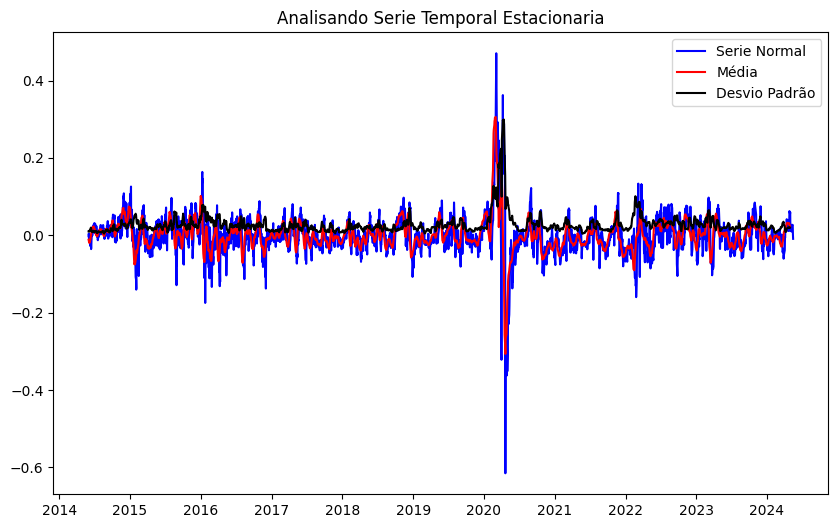

In [ ]:
test_stationarity(datasetLogScaleMinusMovingAverage)

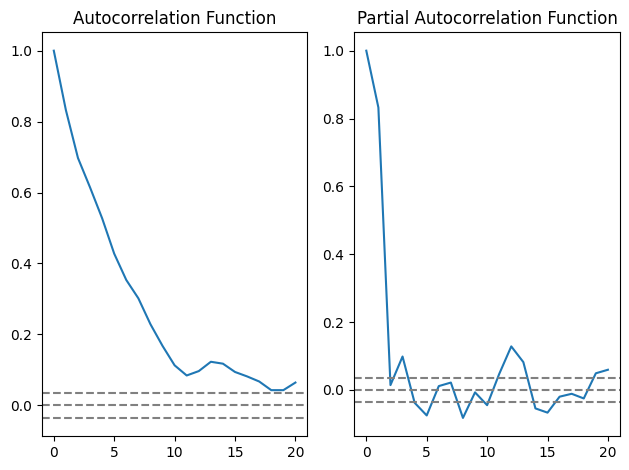

In [ ]:
lag_acf = acf(datasetLogScaleMinusMovingAverage, nlags=20)
lag_pacf = pacf(datasetLogScaleMinusMovingAverage, nlags=20, method='ols')

#ACF:
plt.subplot(121)
plt.plot(lag_acf)
plt.axhline(y=0, linestyle='--', color='gray')
plt.axhline(y=-1.96/np.sqrt(len(datasetLogScaleMinusMovingAverage)), linestyle='--', color='gray')
plt.axhline(y=1.96/np.sqrt(len(datasetLogScaleMinusMovingAverage)), linestyle='--', color='gray')
plt.title('Autocorrelation Function')
plt.ylabel('')
plt.xlabel('')

#PACF
plt.subplot(122)
plt.plot(lag_pacf)
plt.axhline(y=0, linestyle='--', color='gray')
plt.axhline(y=-1.96/np.sqrt(len(datasetLogScaleMinusMovingAverage)), linestyle='--', color='gray')
plt.axhline(y=1.96/np.sqrt(len(datasetLogScaleMinusMovingAverage)), linestyle='--', color='gray')
plt.title('Partial Autocorrelation Function')
plt.ylabel('')
plt.xlabel('')

plt.tight_layout()


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it is not monotonic and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it is not monotonic and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsm

Plotting AR model


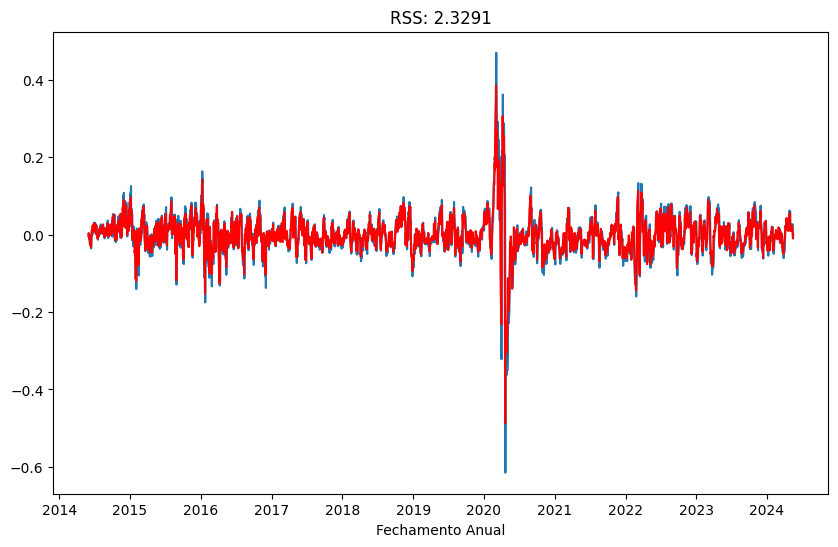

In [ ]:
model = ARIMA(datasetLogScaleMinusMovingAverage, order=(2,1,18))#(p,d,q)
results_AR = model.fit()


plt.figure(figsize=(10,6))
plt.title('')
plt.ylabel('')
plt.xlabel('Fechamento Anual')

ax = plt.gca()
ax.xaxis.set_major_locator(mdates.YearLocator())
plt.plot(datasetLogScaleMinusMovingAverage)
plt.plot(results_AR.fittedvalues, color='red')
plt.title('RSS: %.4f'%sum((results_AR.fittedvalues - datasetLogScaleMinusMovingAverage['Preco_petroleo'])**2))



print('Plotting AR model')

In [ ]:
predictions = results_AR.fittedvalues
predictions.index = datasetLogScaleMinusMovingAverage.index
predicted_values = indexedDataset_logScale['Preco_petroleo'].iloc[0] + np.cumsum(predictions)

mape = mean_absolute_error(datasetLogScaleMinusMovingAverage['Preco_petroleo'], predicted_values) * 100
mae = mean_absolute_error(datasetLogScaleMinusMovingAverage['Preco_petroleo'], predicted_values)
mse = mean_squared_error(datasetLogScaleMinusMovingAverage['Preco_petroleo'], predicted_values)
rmse = np.sqrt(mse)
print(f"MAPE: {mape:.2f}")
print(f"MAE: {mae:.2f}")
print(f"MSE: {mse:.2f}")
print(f"RMSE: {rmse:.2f}")

MAPE: 312.76
MAE: 3.13
MSE: 12.01
RMSE: 3.47
